In [67]:
from tqdm import tqdm
import numpy as np

import torch
import shap
import torch.nn as nn

from train import train, test

from ldl.data import get_episodic_loader
from ldl.models import RNDModel
import matplotlib.pyplot as plt

In [68]:
dataset = 'mnist'
way = 10
train_shot = 300
test_shot = 5
mse_loss = nn.MSELoss(reduction='none')
trials = 1
epochs = 3
silent = True
split = 'test'
add_rotations = True
in_alphabet = False
x_dim = 28
z_dim = 2000
c = 1
optimizer = 'adam'
lr = 5e-05
initialization = 'xavier_normal'
gpu = 2

In [69]:
device = torch.device(f"cuda:{gpu}" if torch.cuda.is_available() else "cpu")

accs = []
dataloader = get_episodic_loader(dataset, way, train_shot, test_shot, x_dim,
                                 split=split,
                                 add_rotations=add_rotations,
                                 in_alphabet=in_alphabet)

In [11]:
model = RNDModel(way, in_dim=c*x_dim**2, out_dim=z_dim, opt=optimizer,
                         lr=lr, initialization=initialization)#, dld=dld)
model.to(device)

for sample in dataloader:
    x_train = sample['xs'].reshape((-1, c*x_dim**2))
    y_train = np.asarray(
        [i // train_shot for i in range(train_shot * way)])
    x_test = sample['xq'].reshape((-1, c*x_dim**2))
    y_test = np.asarray(
        [i // test_shot for i in range(test_shot * way)])

    x_train = torch.tensor(x_train)
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)
    y_test = torch.tensor(y_test)

    # print("Train: ", x_train.shape, y_train.shape)
    # print("Test: ", x_test.shape, y_test.shape)

    inds = np.random.permutation(x_train.shape[0])
    samples_train = list(zip(x_train[inds], y_train[inds]))
    samples_test = list(zip(x_test, y_test))

    train(model, loss_func=mse_loss, train_loader=samples_train, epochs=epochs,
          silent=silent, device=device)
    accs.append(test(model, samples_test, silent=silent, device=device))


<ipython-input-11-344d42eb29d8>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train)
<ipython-input-11-344d42eb29d8>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test)


In [70]:
model

RNDModel(
  (target): Sequential(
    (0): Linear(in_features=784, out_features=2000, bias=True)
  )
  (activated_predictor): Sequential(
    (0): Linear(in_features=784, out_features=2000, bias=True)
  )
)

In [19]:
len(x_train)

3000

In [71]:
params = []
for name, param in model.predictors['class_0'].named_parameters():
    params.append(param)

In [59]:
np_params_w = torch.tensor(params[0]).cpu().numpy()
np_params_b = torch.tensor(params[1]).cpu().numpy()

<ipython-input-59-6d2fbdbe3cc6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  np_params_w = torch.tensor(params[0]).cpu().numpy()
<ipython-input-59-6d2fbdbe3cc6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  np_params_b = torch.tensor(params[1]).cpu().numpy()


In [66]:
len(np_params_w[0])

784

In [65]:
np_params_w.shape

(2000, 784)

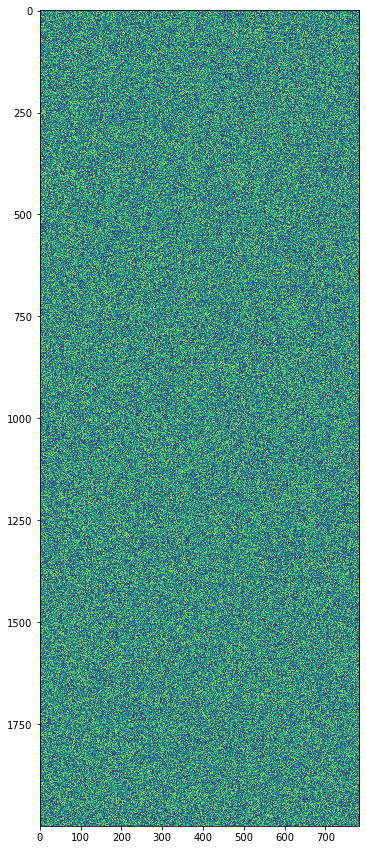

In [60]:
plt.figure(figsize=(20, 15))
plt.imshow(np_params_w, interpolation='none')

In [ ]:
np_params_

In [63]:
np_params_w.shape

(2000, 784)

TypeError: Invalid shape (2000,) for image data

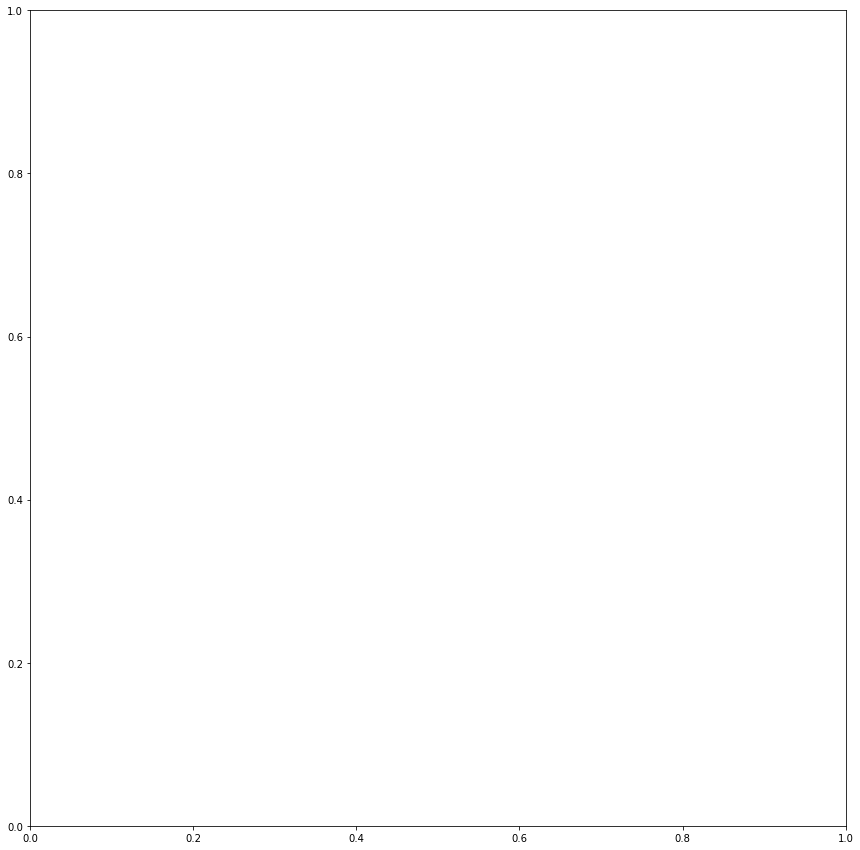

In [61]:
plt.figure(figsize=(20, 15))
plt.imshow(np_params_b, interpolation='none')

In [54]:
np_params

array([[-0.03296541,  0.00323338, -0.02230706, ..., -0.02366865,
        -0.0133095 ,  0.00128804],
       [-0.01547611, -0.03143414, -0.02082005, ..., -0.0005121 ,
        -0.00702378, -0.0266439 ],
       [ 0.02735021,  0.0024222 , -0.02694647, ...,  0.01014677,
         0.01022385,  0.02920713],
       ...,
       [-0.0222553 , -0.02584762,  0.024393  , ..., -0.00040769,
        -0.0203476 , -0.02849678],
       [-0.01308409,  0.02130635, -0.02095054, ...,  0.01189808,
         0.01098995,  0.02425356],
       [-0.00212155, -0.00703884,  0.03319519, ...,  0.02018408,
         0.02608138,  0.02235733]], dtype=float32)

In [34]:
model.predictors['class_0']._

OrderedDict()

In [27]:
e = shap.DeepExplainer(
        model.predictors['class_0'], 
        x_train[np.random.choice(np.arange(len(x_train)), 1000, replace=False)].to(device))

In [33]:
%%time
x_samples = x_train[np.random.choice(np.arange(len(x_train)), 500, replace=False)].to(device)
print(len(x_samples))
shap_values = e.shap_values(x_samples).to(device)

500


/nfs/home/iglukhov/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": features
})
df.sort_values("mean_abs_shap", ascending=False)[:10]